In [1]:
import os
from itertools import product
import pandas as pd
import multiprocessing as mp

In [2]:
import subprocess

## IMPORTANT: Make sure that "Uniandes_Framework" is in .gitignore
framework_path = "Uniandes_Framework"

if os.path.exists(framework_path):
    # Pull updates if the framework is already cloned
    try:
        subprocess.run(["git", "-C", framework_path, "pull"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while pulling updates from the framework: {e}")
else:
    # Clone the framework if it is not already cloned
    try:
        subprocess.run(["git", "clone", "git@github.com:Phenomenology-group-uniandes/Uniandes_Framework.git"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while cloning the framework: {e}")
   
from Uniandes_Framework.delphes_reader.lhereader import LHE_Loader, readLHEF, get_event_by_child
from Uniandes_Framework.delphes_reader.root_analysis import get_kinematics_row, make_histograms, overlap_histos

hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.


Already up to date.
Welcome to JupyROOT 6.22/06


In [3]:
case = "woRHC"
sim_path = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))), "SIMULATIONS", f"lq_zp_{case}")
signals = ["ta_ta","zp_tau_tau"]
xs_path = { signal: os.path.join( os.path.dirname(os.getcwd()), "01_signal_production", f"xs_signals_{case}", signal, "XS_Matrix.csv") for signal in signals}
                       
M_U= [1000]
G_U = [1.5]

csv_sim_path = pd.read_csv(os.path.join("Uniandes_Framework", "SimulationsPaths.csv"))
df = pd.concat(
    [csv_sim_path]
    +
    [ pd.DataFrame.from_dict(
    {
        "name" : signal + f"_m{m}_g{g}", 
        "path": os.path.join(sim_path, signal,f'M{m}_gU{g:.4f}'.replace('.', '_')),  
        'xs(pb)': pd.read_csv(xs_path[signal], index_col = 0).loc[g,str(m)]
    }, 
    orient = "index").T for signal, m , g in product(signals,M_U,G_U) ]
)
# save the new csv
csv_sim_path = os.path.join(os.getcwd(), "SimulationsPaths.csv")
df.to_csv(csv_sim_path, index = False)


In [4]:
def get_kinematics(run):
    run_name = os.path.basename(os.path.dirname(run))
    childs=readLHEF(run)
    if os.path.isfile(run):
        print('Reading', run_name)
    else:
        pass
    
    results = list()
    for child in childs:
        event = get_event_by_child(child)
        taus = event.getParticlesByIDs([-15,15])
        if len(taus) == 2:
            taus[0].SetName("#tau_{1}")
            taus[1].SetName("#tau_{2}")
        else :
            continue
        results.append(get_kinematics_row(taus))
    print(run_name, 'done!')
    return results


In [5]:
# Load the simulation

def load_simulation(x):
    signal, m, g = x
    lhe_loader = LHE_Loader(signal + f"_m{m}_g{g}", csv_sim_path)
    results = list()
    
    n_cores = 3
    with mp.Pool(n_cores) as pool:
        for result in list(pool.map(get_kinematics, lhe_loader.Forest)):
            results += result
    return signal, pd.DataFrame.from_records(results)

In [6]:
a = dict(map(load_simulation, product(signals,M_U,G_U)))

ta_ta_m1000_g1.5 imported with 12 trees!
/home/Cristian/SIMULATIONS/lq_zp_woRHC/ta_ta/M1000_gU1_5000
Reading run_03
Reading run_02
Reading run_01
run_03 done!
run_02 done!
run_01 done!
Reading run_05
Reading run_04
run_05 done!
Reading run_06
run_04 done!
run_06 done!
Reading run_07
Reading run_08
run_07 done!
Reading run_09
run_08 done!
run_09 done!
Reading run_10
Reading run_11
Reading run_12
run_10 done!
run_11 done!
run_12 done!
zp_tau_tau_m1000_g1.5 imported with 12 trees!
/home/Cristian/SIMULATIONS/lq_zp_woRHC/zp_tau_tau/M1000_gU1_5000
Reading run_02
Reading run_01
Reading run_03
run_02 done!
run_01 done!
run_03 done!
Reading run_04
Reading run_05
Reading run_06
run_04 done!
run_05 done!
run_06 done!
Reading run_07
run_07 done!
Reading run_08
run_08 done!
Reading run_09
run_09 done!
Reading run_10
run_10 done!
Reading run_11
run_11 done!
Reading run_12
run_12 done!


In [13]:
a['ta_ta'].head()

,pT_{#tau_{1}}(GeV),#eta_{#tau_{1}},#phi_{#tau_{1}},Energy_{#tau_{1}}(GeV),Mass_{#tau_{1}}(GeV)),#Delta{R}_{#tau_{1}#tau_{2}},#Delta{#eta}_{#tau_{1}#tau_{2}},#Delta{#phi}_{#tau_{1}#tau_{2}},#Delta{pT}_{#tau_{1}#tau_{2}}(GeV),#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV),#Delta{#vec{p}}_{#tau_{1}#tau_{2}}(GeV),pT_{#tau_{2}}(GeV),#eta_{#tau_{2}},#phi_{#tau_{2}},Energy_{#tau_{2}}(GeV),Mass_{#tau_{2}}(GeV))
0,39.378457,1.121557,-2.843818,66.852843,-0.000117,3.317725,1.066626,3.141593,0.0,78.756913,94.298140,39.378457,0.054930,0.297775,39.437881,-0.000113
1,81.171911,-2.366061,0.293627,436.265931,0.001276,3.698799,-1.952310,3.141593,0.0,162.343822,426.224810,81.171911,-0.413751,-2.847966,88.219507,0.000249
2,80.503619,0.920527,1.654172,117.089376,-0.000350,3.290347,-0.978149,3.141593,0.0,161.007237,239.800953,80.503619,1.898676,-1.487421,274.791724,-0.001676
3,154.868804,1.327372,1.113473,312.548023,0.001734,3.334072,1.116436,3.141593,0.0,309.737608,390.964653,154.868804,0.210937,-2.028119,158.326983,-0.000404
4,51.064710,-0.695411,-0.378432,63.917733,-0.000152,3.275737,-0.927819,3.141593,0.0,102.129419,113.896459,51.064710,0.232409,2.763161,52.450026,0.000156


In [8]:
default_hist_bins_dict={
    "#Delta{R}":[96,0,7],
    "#Delta{#eta}":[80,-5,5],
    "#Delta{#phi}":[52,-3.25,3.25],
    "#Delta{pT}":[120, 0.0, 1500.0],
    "#Delta{#vec{pT}}":[240, 0.0, 4800.0],
    "#Delta{#vec{p}}":[240, 0.0, 4800.0],
    "MET(GeV)":[80, 0.0, 1000.0],
    "pT_": [160, 0.0, 2000.0],
    "sT(GeV)": [200, 0.0, 4000.0],
    "mT(GeV)": [200, 0.0, 4000.0],
    "#eta_":[80, -5, 5],
    "#phi_":[128, -3.2, 3.2],
    "Energy_":[80, 0.0, 1000.0]
}
root_histos ={ signal: make_histograms(a[signal],hist_bins_dict = default_hist_bins_dict) for signal in signals}

In [9]:
root_histos

{'ta_ta': {'pT_{#tau_{1}}(GeV)': <cppyy.gbl.TH1F object at 0x55f205878f30>,
  '#eta_{#tau_{1}}': <cppyy.gbl.TH1F object at 0x55f20cea7600>,
  '#phi_{#tau_{1}}': <cppyy.gbl.TH1F object at 0x55f20cebc400>,
  'Energy_{#tau_{1}}(GeV)': <cppyy.gbl.TH1F object at 0x55f20ced84f0>,
  '#Delta{R}_{#tau_{1}#tau_{2}}': <cppyy.gbl.TH1F object at 0x55f20ced8a00>,
  '#Delta{#eta}_{#tau_{1}#tau_{2}}': <cppyy.gbl.TH1F object at 0x55f20ced4080>,
  '#Delta{#phi}_{#tau_{1}#tau_{2}}': <cppyy.gbl.TH1F object at 0x55f20cec6420>,
  '#Delta{pT}_{#tau_{1}#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55f20ced44c0>,
  '#Delta{#vec{pT}}_{#tau_{1}#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55f20cee2120>,
  '#Delta{#vec{p}}_{#tau_{1}#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55f20cf6e200>,
  'pT_{#tau_{2}}(GeV)': <cppyy.gbl.TH1F object at 0x55f20cf5dbd0>,
  '#eta_{#tau_{2}}': <cppyy.gbl.TH1F object at 0x55f20cf4ec20>,
  '#phi_{#tau_{2}}': <cppyy.gbl.TH1F object at 0x55f20cf92630>,
  'Energy_{#tau_{2}}(GeV)': <cppy

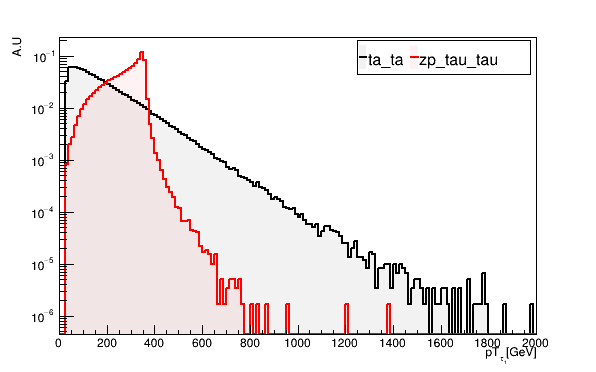

In [10]:
histos, canvas, legend = overlap_histos( 'pT_{#tau_{1}}(GeV)', root_histos, log_scale =True)

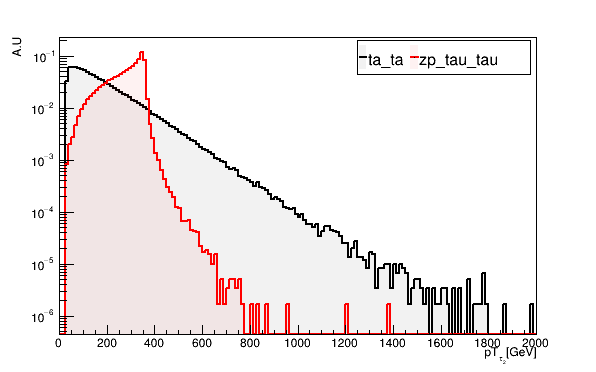

In [11]:
histos, canvas, legend = overlap_histos( 'pT_{#tau_{2}}(GeV)', root_histos, log_scale =True)

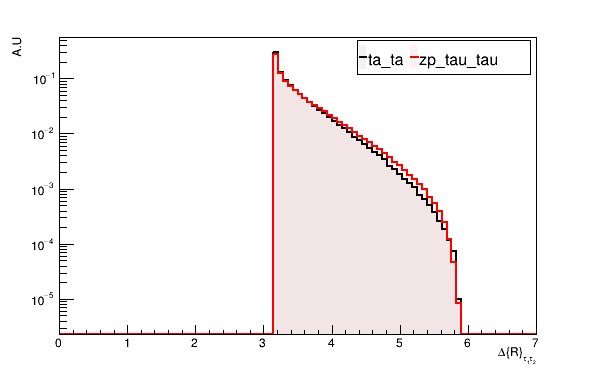

In [12]:
histos, canvas, legend = overlap_histos('#Delta{R}_{#tau_{1}#tau_{2}}', root_histos, log_scale =True)